In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.io import read_image

class Birds270Dataset(Dataset):
    def make_labels(self, csv_table):
        bird_str_labels = csv_table["labels"].unique()
        self.labels_str_to_int = {label:i  for i, label in enumerate(bird_str_labels)}
        self.labels_int_to_str = {i:label  for i, label in enumerate(bird_str_labels)}
        
    def __init__(self, dataset_dir, set_type="train", transform=None, selected_birds=None):
        csv_table = pd.read_csv(os.path.join(dataset_dir, "birds.csv"))
        if selected_birds != None:
            csv_table = csv_table[csv_table["labels"].isin(selected_birds)]
        self.img_data = csv_table[csv_table["data set"]==set_type]
        self.make_labels(self.img_data)
        self.dataset_dir = dataset_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        filepaths_col = self.img_data.columns.get_loc("filepaths")
        labels_col = self.img_data.columns.get_loc("labels")
        img_path = os.path.join(self.dataset_dir, self.img_data.iat[idx, filepaths_col])
        image = read_image(img_path).float()
        label = self.img_data.iat[idx, labels_col]
        if self.transform:
            image = self.transform(image)
        int_label = self.labels_str_to_int[label]
        return image, int_label
    



In [3]:
def make2d(int_or_tuple):
    if(type(int_or_tuple) is int):
        return (int_or_tuple,int_or_tuple)
    else:
        return int_or_tuple
# Returns the dimensions of the image after performing nn.Conv2d
def dim_conv2d(size_in, kernel_size, stride=1, padding=0, dilation=1):
    kernel_size = make2d(kernel_size)
    stride = make2d(stride)
    padding = make2d(padding)
    dilation = make2d(dilation)
    height_out = int((size_in[0] + 2*padding[0] - dilation[0]*(kernel_size[0]-1) - 1)/stride[0] + 1)
    width_out = int((size_in[1] + 2*padding[1] - dilation[1]*(kernel_size[1]-1) - 1)/stride[1] + 1)
    return (height_out, width_out)

# Returns the dimensions of the image after performing nn.MaxPool2d
def dim_maxpool2d(size_in, kernel_size, stride=None, padding=0, dilation=1):
    if stride == None:
        stride = kernel_size
    # The formula is the same as for dim_conv2d
    return dim_conv2d(size_in, kernel_size, stride=stride, padding=padding, dilation=dilation)


In [17]:
dataset_dir = "../data/birds270"
selected_birds = ["ALBATROSS", "BALD EAGLE", "BARN OWL", "EURASIAN MAGPIE", "FLAMINGO",
                  "MALLARD DUCK", "OSTRICH", "PEACOCK", "PELICAN", "TRUMPTER SWAN"]
tr = transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5)) # normalizes colors to range [-1,1]
train_dataset = Birds270Dataset(dataset_dir, set_type="train", selected_birds=selected_birds, transform=tr)
test_dataset = Birds270Dataset(dataset_dir, set_type="valid", selected_birds=selected_birds, transform=tr)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime

kernel_size = 5

def conv_out_size(height, width):
    dim = (height, width)
    dim = dim_conv2d(dim, kernel_size)
    dim = dim_maxpool2d(dim, 2, 2)
    dim = dim_conv2d(dim, kernel_size)
    dim = dim_maxpool2d(dim, 2, 2)
    return dim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size)
        conv_height, conv_width = conv_out_size(224, 224)
        self.fc1 = nn.Linear(16 * conv_width * conv_height, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train(net, train_dataloader, criterion, optimizer, device="cpu"):
    net.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(train_dataloader.dataset)
    return {"loss":epoch_loss}

def evaluate(net, test_dataloader, criterion, device="cpu"):
    net.eval()
    correct = 0
    total = 0
    correct_labels = {label_str: 0 for label_str in test_dataset.labels_str_to_int.keys()}
    total_labels = {label_str: 0 for label_str in test_dataset.labels_str_to_int.keys()}
    running_loss = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_labels[test_dataset.labels_int_to_str[label.item()]] += 1
                total_labels[test_dataset.labels_int_to_str[label.item()]] += 1
    epoch_loss = running_loss / len(test_dataloader.dataset)
    return {"correct":correct, "total":total, "loss":epoch_loss, "correct_labels":correct_labels, "total_labels":total_labels}

def print_label_accuracy(correct_labels, total_labels):
    for label_str, correct_label in correct_labels.items():
        total_label = total_labels[label_str]
        print(f"\t{label_str}: {100 * correct_label / total_label}")
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(net.parameters())

for epoch in range(30):
    start_time = datetime.datetime.now()
    train_results = train(net, train_dataloader, criterion, optimizer, device=device)
    results = evaluate(net, test_dataloader, criterion, device=device)
    time_elapsed = datetime.datetime.now() - start_time
    train_loss = train_results["loss"]
    val_loss = results["loss"]
    accuracy = results["correct"]/results["total"]
    print(f"Epoch {epoch}:")
    print(f"\ttrain loss: {train_loss}")
    print(f"\tvalidation loss: {val_loss}, validation accuracy: {100 * accuracy}%")
    print(f"\tElapsed time: {time_elapsed}")

final_results = evaluate(net, test_dataloader, criterion)
final_loss = final_results["loss"]
final_accuracy = final_results["correct"]/final_results["total"]
print(f"Final loss: {final_loss}, final accuracy: {100*final_accuracy} %")
print_label_accuracy(final_results["correct_labels"], final_results["total_labels"])

torch.save(net, '../model/simple_DB_model.pth')
torch.save(net.state_dict(), '../model/simple_DB_model_weights.pth')


Device: cpu
Epoch 0:
	train loss: 1.974192177248633
	validation loss: 1.5818072605133056, validation accuracy: 44.0%
	Elapsed time: 0:00:10.563289
Epoch 1:
	train loss: 1.1842856810089415
	validation loss: 1.0641307973861693, validation accuracy: 60.0%
	Elapsed time: 0:00:10.926269
Epoch 2:
	train loss: 0.651355834044132
	validation loss: 0.8964224338531495, validation accuracy: 74.0%
	Elapsed time: 0:00:10.000490
Epoch 3:
	train loss: 0.26935223638133554
	validation loss: 0.7496171569824219, validation accuracy: 76.0%
	Elapsed time: 0:00:10.525557
Epoch 4:
	train loss: 0.09526394790968418
	validation loss: 0.9304060029983521, validation accuracy: 72.0%
	Elapsed time: 0:00:11.134079
Epoch 5:
	train loss: 0.02729334112836956
	validation loss: 0.9876253414154053, validation accuracy: 76.0%
	Elapsed time: 0:00:10.528353
Epoch 6:
	train loss: 0.020181446150356743
	validation loss: 1.3238849544525146, validation accuracy: 66.0%
	Elapsed time: 0:00:10.469766
Epoch 7:
	train loss: 0.008505631

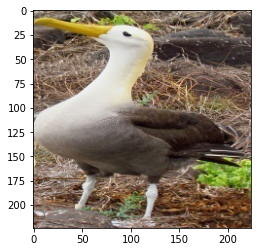

Label (number): 0, (name): ALBATROSS
[('PEACOCK', 0.5470597743988037), ('OSTRICH', 0.22739006578922272), ('BARN OWL', 0.10338650643825531), ('FLAMINGO', 0.10161847621202469), ('MALLARD DUCK', 0.009700717404484749), ('BALD EAGLE', 0.007645148318260908), ('TRUMPTER SWAN', 0.0031220295932143927), ('EURASIAN MAGPIE', 6.40603102510795e-05), ('ALBATROSS', 1.2702493222604971e-05), ('PELICAN', 4.999705538466515e-07)]


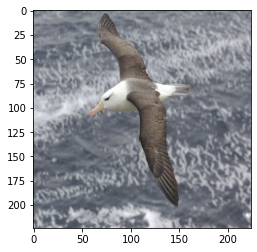

Label (number): 0, (name): ALBATROSS
[('ALBATROSS', 0.6259844899177551), ('PELICAN', 0.368598073720932), ('TRUMPTER SWAN', 0.002229835605248809), ('EURASIAN MAGPIE', 0.0018938641296699643), ('PEACOCK', 0.0011778691550716758), ('MALLARD DUCK', 7.237079262267798e-05), ('BARN OWL', 2.395448973402381e-05), ('FLAMINGO', 9.004771527543198e-06), ('BALD EAGLE', 6.752390163455857e-06), ('OSTRICH', 3.76558614334499e-06)]


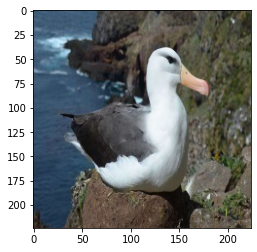

Label (number): 0, (name): ALBATROSS
[('ALBATROSS', 0.9999775886535645), ('PELICAN', 2.005187707254663e-05), ('BALD EAGLE', 1.8713152485361206e-06), ('PEACOCK', 3.836495920950256e-07), ('EURASIAN MAGPIE', 8.824150654618279e-08), ('MALLARD DUCK', 1.503926405632683e-08), ('TRUMPTER SWAN', 6.915947370345066e-09), ('OSTRICH', 2.4593669323280665e-09), ('BARN OWL', 1.2645039459968643e-09), ('FLAMINGO', 6.676112440651139e-10)]


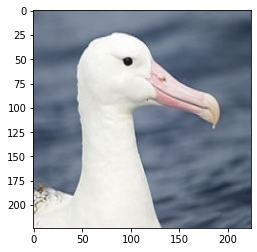

Label (number): 0, (name): ALBATROSS
[('PELICAN', 0.9674525856971741), ('TRUMPTER SWAN', 0.029593927785754204), ('ALBATROSS', 0.002602918539196253), ('FLAMINGO', 0.00017293068231083453), ('BARN OWL', 0.00016145064728334546), ('BALD EAGLE', 1.110550329030957e-05), ('OSTRICH', 5.027295173931634e-06), ('PEACOCK', 7.215421504724873e-08), ('EURASIAN MAGPIE', 7.632448451033724e-09), ('MALLARD DUCK', 2.2098599339326341e-10)]


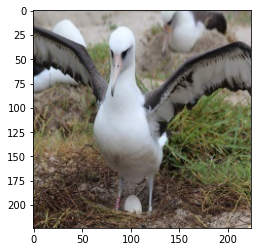

Label (number): 0, (name): ALBATROSS
[('PELICAN', 0.5124871134757996), ('ALBATROSS', 0.42555001378059387), ('BARN OWL', 0.06066557392477989), ('PEACOCK', 0.0008714888826943934), ('FLAMINGO', 0.00042466213926672935), ('EURASIAN MAGPIE', 8.912974749364366e-07), ('OSTRICH', 9.778915455171955e-08), ('BALD EAGLE', 8.452355615418128e-08), ('MALLARD DUCK', 3.089513000986699e-08), ('TRUMPTER SWAN', 3.0277810481038614e-08)]


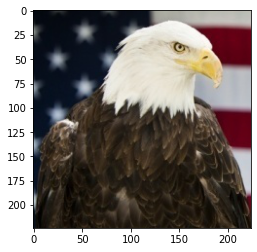

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.9975442290306091), ('ALBATROSS', 0.0021275412291288376), ('FLAMINGO', 0.0002709889377001673), ('BARN OWL', 5.707985837943852e-05), ('OSTRICH', 7.997688555860805e-08), ('PEACOCK', 8.551813146517873e-10), ('MALLARD DUCK', 3.809064730297962e-10), ('PELICAN', 8.175102261809286e-11), ('TRUMPTER SWAN', 3.186478511607582e-11), ('EURASIAN MAGPIE', 9.371315877438561e-15)]


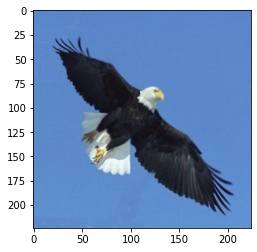

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.9998313188552856), ('EURASIAN MAGPIE', 0.00016773524112068117), ('ALBATROSS', 9.816237707127584e-07), ('OSTRICH', 1.408664518365299e-09), ('MALLARD DUCK', 1.3378432042743249e-11), ('PELICAN', 4.02233888557868e-12), ('PEACOCK', 8.898432121359767e-13), ('TRUMPTER SWAN', 3.8557339558566855e-14), ('FLAMINGO', 4.6638491500225476e-20), ('BARN OWL', 9.172244526927707e-22)]


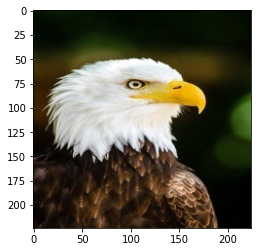

Label (number): 1, (name): BALD EAGLE
[('BARN OWL', 0.9258965849876404), ('BALD EAGLE', 0.045987289398908615), ('FLAMINGO', 0.026242604479193687), ('ALBATROSS', 0.0010655458318069577), ('PELICAN', 0.0008055321522988379), ('TRUMPTER SWAN', 1.974680571947829e-06), ('OSTRICH', 4.7459724328291486e-07), ('PEACOCK', 4.2545359235646174e-08), ('MALLARD DUCK', 1.0224814328552156e-09), ('EURASIAN MAGPIE', 2.353472573616601e-14)]


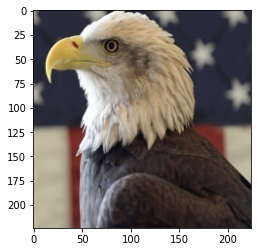

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.704167366027832), ('FLAMINGO', 0.17027270793914795), ('BARN OWL', 0.11633569747209549), ('OSTRICH', 0.008969220332801342), ('ALBATROSS', 0.00023514655185863376), ('MALLARD DUCK', 1.4640801055065822e-05), ('PEACOCK', 5.217685611569323e-06), ('PELICAN', 2.5790006574766267e-08), ('TRUMPTER SWAN', 1.0497744895587857e-08), ('EURASIAN MAGPIE', 9.086219776577309e-09)]


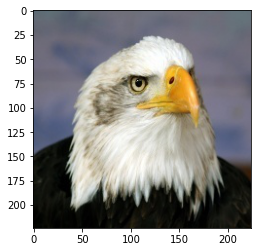

Label (number): 1, (name): BALD EAGLE
[('BALD EAGLE', 0.9989721775054932), ('TRUMPTER SWAN', 0.0005470491596497595), ('ALBATROSS', 0.0004110510053578764), ('PELICAN', 6.919321458553895e-05), ('BARN OWL', 3.6488239629761665e-07), ('OSTRICH', 8.780341431702254e-08), ('FLAMINGO', 2.210927441126387e-09), ('MALLARD DUCK', 2.1684620765682894e-09), ('PEACOCK', 3.59611507239066e-10), ('EURASIAN MAGPIE', 3.644210367498291e-12)]


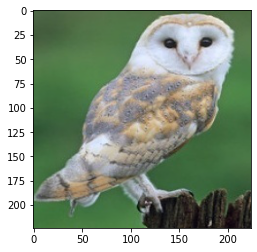

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.9957333207130432), ('PELICAN', 0.0021976178977638483), ('TRUMPTER SWAN', 0.001568815903738141), ('ALBATROSS', 0.00038355105789378285), ('FLAMINGO', 8.237270958488807e-05), ('BALD EAGLE', 3.0227922252379358e-05), ('OSTRICH', 3.7490481190616265e-06), ('PEACOCK', 3.1878397521722945e-07), ('MALLARD DUCK', 4.1412011597685705e-09), ('EURASIAN MAGPIE', 1.976060634567567e-11)]


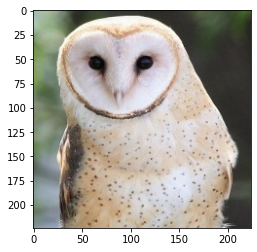

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.46018922328948975), ('FLAMINGO', 0.32586172223091125), ('ALBATROSS', 0.1365433931350708), ('TRUMPTER SWAN', 0.0483948215842247), ('BALD EAGLE', 0.027662821114063263), ('OSTRICH', 0.0010898268083110452), ('PELICAN', 0.00021891111100558192), ('MALLARD DUCK', 2.784995740512386e-05), ('EURASIAN MAGPIE', 7.858176104491577e-06), ('PEACOCK', 3.505496579236933e-06)]


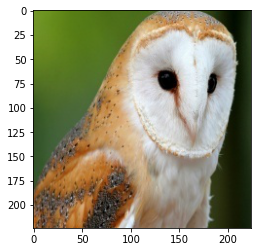

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.9859515428543091), ('TRUMPTER SWAN', 0.013748408295214176), ('FLAMINGO', 0.00028330873465165496), ('PELICAN', 1.5500019799219444e-05), ('OSTRICH', 7.763532607896195e-07), ('ALBATROSS', 4.107145628040598e-07), ('BALD EAGLE', 9.371196085794509e-08), ('PEACOCK', 8.447386123933143e-10), ('MALLARD DUCK', 3.620315991437195e-10), ('EURASIAN MAGPIE', 1.2686065305883565e-12)]


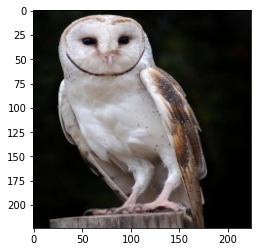

Label (number): 2, (name): BARN OWL
[('BARN OWL', 1.0), ('FLAMINGO', 2.971160917297766e-08), ('PELICAN', 1.114036596305823e-08), ('ALBATROSS', 6.694487186820197e-09), ('BALD EAGLE', 3.0418969565459975e-09), ('OSTRICH', 2.5578551429705776e-11), ('TRUMPTER SWAN', 1.255372542030564e-11), ('PEACOCK', 4.51587291866451e-12), ('MALLARD DUCK', 1.2025088524152887e-15), ('EURASIAN MAGPIE', 4.9586246548286224e-21)]


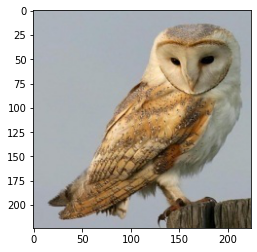

Label (number): 2, (name): BARN OWL
[('BARN OWL', 0.9982055425643921), ('FLAMINGO', 0.0016104766400530934), ('OSTRICH', 8.717951277503744e-05), ('PELICAN', 7.06583887222223e-05), ('MALLARD DUCK', 1.8065264157485217e-05), ('BALD EAGLE', 7.40646419217228e-06), ('ALBATROSS', 4.831063051824458e-07), ('TRUMPTER SWAN', 7.457786921349907e-08), ('EURASIAN MAGPIE', 2.7162666782487577e-08), ('PEACOCK', 2.2976132107999092e-09)]


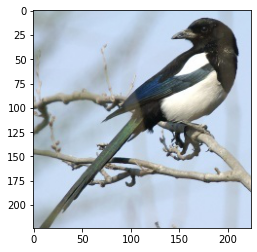

Label (number): 3, (name): EURASIAN MAGPIE
[('TRUMPTER SWAN', 0.6481179594993591), ('EURASIAN MAGPIE', 0.18369528651237488), ('ALBATROSS', 0.1547539234161377), ('PELICAN', 0.009319405071437359), ('MALLARD DUCK', 0.004027951043099165), ('FLAMINGO', 5.790441719000228e-05), ('BALD EAGLE', 2.691065128601622e-05), ('PEACOCK', 5.428603913060215e-07), ('OSTRICH', 1.900214812167178e-07), ('BARN OWL', 9.073694684502698e-09)]


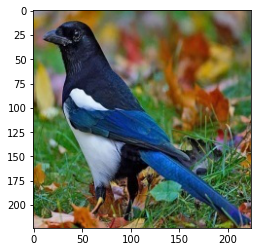

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.9999566078186035), ('PEACOCK', 3.9829803426982835e-05), ('MALLARD DUCK', 3.3108592560893157e-06), ('OSTRICH', 8.992529387796822e-08), ('ALBATROSS', 4.689457355766535e-08), ('PELICAN', 2.596545556343699e-08), ('BALD EAGLE', 7.684543668062815e-09), ('TRUMPTER SWAN', 5.237093536614168e-10), ('FLAMINGO', 8.391032313426194e-11), ('BARN OWL', 6.031329949363062e-14)]


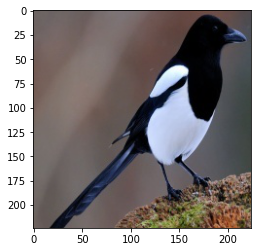

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.9999998807907104), ('OSTRICH', 1.186020881505101e-07), ('BALD EAGLE', 2.0711039550036503e-09), ('PELICAN', 7.183734718196888e-10), ('FLAMINGO', 4.3212197708975e-10), ('ALBATROSS', 3.7338238056960904e-10), ('TRUMPTER SWAN', 2.0517259766150708e-11), ('PEACOCK', 1.6183871950903317e-11), ('MALLARD DUCK', 7.86997203516826e-12), ('BARN OWL', 1.4736094763596712e-14)]


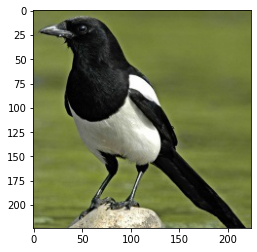

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.9994949102401733), ('OSTRICH', 0.0005049746832810342), ('MALLARD DUCK', 1.4456297492415615e-07), ('PEACOCK', 7.500954024575179e-11), ('BALD EAGLE', 7.447551603201319e-11), ('PELICAN', 7.41205291587832e-11), ('BARN OWL', 3.280410340068818e-13), ('FLAMINGO', 1.148321346865211e-13), ('ALBATROSS', 2.492615861708191e-14), ('TRUMPTER SWAN', 4.0639757380367124e-17)]


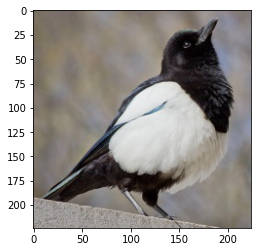

Label (number): 3, (name): EURASIAN MAGPIE
[('EURASIAN MAGPIE', 0.9944199919700623), ('PELICAN', 0.005579850636422634), ('TRUMPTER SWAN', 7.895703646454422e-08), ('MALLARD DUCK', 5.6796473302256345e-08), ('ALBATROSS', 2.8304455668148876e-08), ('FLAMINGO', 1.8421784986344392e-08), ('OSTRICH', 1.3428552492200652e-08), ('BALD EAGLE', 3.766608414057515e-10), ('PEACOCK', 2.0586155002888518e-10), ('BARN OWL', 1.6455146273353094e-11)]


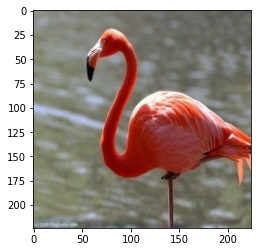

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.9902269840240479), ('OSTRICH', 0.008511796593666077), ('MALLARD DUCK', 0.0012240895302966237), ('BARN OWL', 3.5620945709524676e-05), ('EURASIAN MAGPIE', 1.392025183122314e-06), ('BALD EAGLE', 5.272394787425583e-08), ('ALBATROSS', 1.9357979663681135e-09), ('PELICAN', 4.271877851458328e-10), ('PEACOCK', 8.055285605212958e-11), ('TRUMPTER SWAN', 1.9221377961509134e-12)]


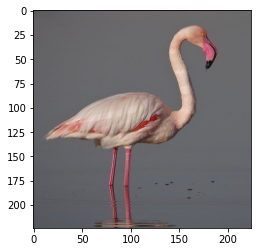

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.9285813570022583), ('MALLARD DUCK', 0.03327745944261551), ('BARN OWL', 0.027414770796895027), ('OSTRICH', 0.006701773032546043), ('ALBATROSS', 0.001594802481122315), ('PELICAN', 0.0014551645144820213), ('EURASIAN MAGPIE', 0.0006112893461249769), ('BALD EAGLE', 0.00028749473858624697), ('PEACOCK', 4.0396687836619094e-05), ('TRUMPTER SWAN', 3.547217420418747e-05)]


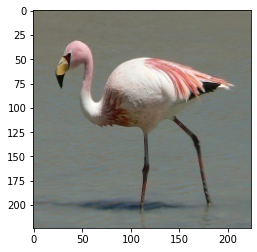

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.9958080053329468), ('OSTRICH', 0.0028044208884239197), ('BARN OWL', 0.001150390482507646), ('PELICAN', 0.00011174536484759301), ('EURASIAN MAGPIE', 0.00010841975745279342), ('ALBATROSS', 8.142656042764429e-06), ('BALD EAGLE', 3.4914712614408927e-06), ('PEACOCK', 3.0083785986789735e-06), ('TRUMPTER SWAN', 1.3637779829878127e-06), ('MALLARD DUCK', 1.0323831247660564e-06)]


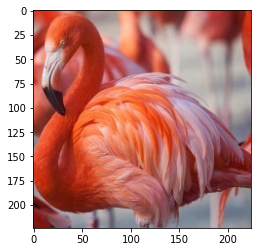

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.9998737573623657), ('BARN OWL', 0.00012623252405319363), ('OSTRICH', 4.607258929922864e-08), ('MALLARD DUCK', 3.970417594700848e-08), ('EURASIAN MAGPIE', 1.4194467649886189e-11), ('BALD EAGLE', 7.823036489440494e-12), ('ALBATROSS', 6.1916010513085595e-12), ('PELICAN', 3.3890340485126166e-14), ('PEACOCK', 3.1350617224869606e-14), ('TRUMPTER SWAN', 1.8035645743301613e-19)]


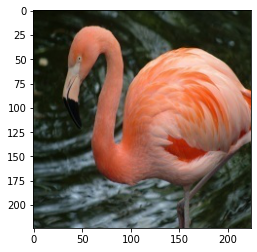

Label (number): 4, (name): FLAMINGO
[('FLAMINGO', 0.9999724626541138), ('BARN OWL', 2.648692679940723e-05), ('BALD EAGLE', 9.474475177739805e-07), ('ALBATROSS', 4.359367977713191e-08), ('OSTRICH', 3.5457098590541136e-08), ('MALLARD DUCK', 1.1530198129605651e-08), ('TRUMPTER SWAN', 4.766100361597303e-11), ('PELICAN', 4.250627280710795e-11), ('PEACOCK', 4.241514257874446e-12), ('EURASIAN MAGPIE', 5.5624961966182704e-14)]


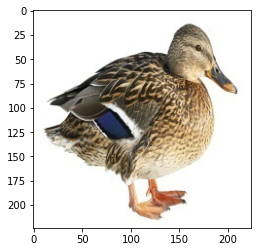

Label (number): 5, (name): MALLARD DUCK
[('MALLARD DUCK', 0.9999996423721313), ('OSTRICH', 2.988983567320247e-07), ('BARN OWL', 1.0186787413601905e-08), ('TRUMPTER SWAN', 1.0694731766847099e-09), ('BALD EAGLE', 2.1245244452572365e-10), ('ALBATROSS', 1.463232313092533e-10), ('FLAMINGO', 1.2871129162483896e-10), ('EURASIAN MAGPIE', 1.1902122343254717e-10), ('PEACOCK', 3.7560410511006115e-12), ('PELICAN', 2.9907239879056746e-12)]


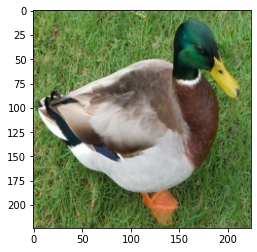

In [ ]:
#function for displaying a picture
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

display_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for data in display_dataloader:
    images, labels = data
    # calculate outputs by running images through the network
    outputs = net(images)
    img = images[0].squeeze()
    label = labels[0].item()
    imshow(img)
    label_str = test_dataset.labels_int_to_str[label]
    print(f"Label (number): {label}, (name): {label_str}")
    prob_tensor = nn.Softmax(dim=1)(outputs.data).squeeze()
    prob_list = prob_tensor.tolist()
    prob_labels = [(test_dataset.labels_int_to_str[i], prob) for i, prob in enumerate(prob_list)]
    prob_labels.sort(key = lambda t : t[1], reverse=True)
    
    print(prob_labels)
    